# Modelado

In [1]:
# Bibliotecas para Modelos de Machine Learning
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier,
                              ExtraTreesClassifier, AdaBoostClassifier, VotingClassifier)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from catboost import CatBoostClassifier

# Bibliotecas para Manipulación de Datos y Análisis
import pandas as pd  # Manipulación de datos
import numpy as np  # Cálculo numérico

# Reducción de Dimensionalidad
from sklearn.decomposition import PCA

# Evaluación de Modelos
from sklearn.metrics import classification_report, mean_squared_error, accuracy_score, r2_score, mean_absolute_error

# Búsqueda de Hiperparámetros y Validación Cruzada
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline  # Creación de pipelines

# Otras Bibliotecas
import joblib  # Serialización de modelos
import matplotlib.pyplot as plt  # Visualización

## Funciones para entrenamiento y testeo

In [2]:
def grid_search_function(model, param_grid, X_train, y_train, pca_components=[0.50, 0.99], cv=2):
    """
    Realiza una búsqueda en cuadrícula (grid search) con validación cruzada
    para encontrar los mejores parámetros de un modelo de aprendizaje automático.

    Parámetros:
    - model: El modelo de aprendizaje automático a utilizar.
    - param_grid (dict): Diccionario de parámetros a probar en la búsqueda en cuadrícula.
    - X_train (array-like): Datos de entrenamiento.
    - y_train (array-like): Etiquetas de entrenamiento.
    - pca_components (list, opcional): Lista de componentes principales (PCA) a probar.
      Predeterminado: [0.50, 0.99]
    - cv (int, opcional): Número de divisiones para la validación cruzada. Predeterminado: 2.

    Retorna:
    tuple: Una tupla que contiene los mejores parámetros, la mejor puntuación,
    el mejor estimador y los resultados de la validación cruzada.
    """
    # Configura el pipeline con las funciones de PCA y el modelo de aprendizaje automático
    pipeline = Pipeline([
        ('pca', PCA()),
        ('classify', model)
    ])

    # Realiza la búsqueda en cuadrícula con validación cruzada utilizando el pipeline anterior
    # y los parámetros del modelo específico
    grid_search = GridSearchCV(pipeline, param_grid, cv=cv, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Obtiene los mejores parámetros del modelo específico
    best_params = grid_search.best_params_

    # Elimina el prefijo 'classify__' de todas las claves
    best_params = {key.replace('classify__', '', 1): value for key, value in best_params.items()}

    return best_params

In [3]:
def train(model, best_params=None):
    """
    Entrena un modelo de aprendizaje automático, opcionalmente utilizando los mejores
    parámetros obtenidos de una búsqueda en cuadrícula (grid search).

    Parámetros:
    - model: El modelo de aprendizaje automático a entrenar.
    - best_params (dict, opcional): Diccionario con los mejores parámetros para el modelo.
      Si no se proporciona, se entrenará el modelo con los parámetros predeterminados.

    Retorna:
    - El modelo entrenado.
    """
    # Si se proporcionan los mejores parámetros, se establecen en el modelo
    if best_params is not None:
        model.set_params(**best_params)

    # Entrena el modelo con los datos de entrenamiento
    return model.fit(X_train, y_train)

In [4]:
def test(model, is_classification=False):
    """
    Evalúa el rendimiento de un modelo de aprendizaje automático en un conjunto de prueba.
    Puede manejar tanto modelos de clasificación como de regresión.

    Parámetros:
    - model: El modelo de aprendizaje automático a evaluar.
    - is_classification (bool, opcional): Indica si el modelo es de clasificación.
      Predeterminado: False (regresión).

    Retorna:
    - y_pred: Las predicciones del modelo en el conjunto de prueba.
    """
    # Realiza las predicciones del modelo en el conjunto de prueba
    y_pred = model.predict(X_test)

    # Si el modelo es de clasificación, calcula y muestra la precisión
    if is_classification:
        result_classification_report = classification_report(y_test, y_pred)
        print(result_classification_report)
    # Si el modelo es de regresión, calcula y muestra el error cuadrático medio y el R²
    else:
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        print(f'Error promedio absoluto: {mae:.2f}')
        print(f'Error Cuadrático Medio: {mse:.2f}')
        print(f'Raiz del error cuadratico medio: {rmse:.2f}')
        print(f'Coeficiente de Determinación (R²): {r2:.2f}')

    return y_pred

### Importacion de datos

In [5]:
path_df_estandarizado_escalado = '../data/2_silver/df_estandarizado_escalado.csv'
df_estandarizado_escalado = pd.read_csv(path_df_estandarizado_escalado)

### Separacion de datos

In [6]:
# separo las las variables de la variable target
X = df_estandarizado_escalado.drop(columns=['subscription_status_encoded'])
y = df_estandarizado_escalado['subscription_status_encoded']
# Divido las variable target y el resto de variables en testeo y prueba utilizando un 35% de datos para prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

### Instancia y evaluacion de modelos

In [7]:
# Se implementara tambien, un modelo simple de arbol de desicion, debido a que si bien hay 10 veces mas registros que cantidad de columnas, no hay un exceso de los mismos
#y esto puede generar sobre ajuste en modelos complejos

# create decision tree model object by ModeloML class
decision_tree_model = DecisionTreeClassifier()

# params for decision tree model
decision_tree_model_params_grid = {
    'classify__max_depth': [None, 10, 20],  # Ajusta estos valores
    'classify__min_samples_split': [2, 5, 10],
    'classify__min_samples_leaf': [1, 2, 4]
}

#obtain best params grid to decision tree model using grid search
decision_tree_model_best_params_grid = grid_search_function(decision_tree_model, param_grid=decision_tree_model_params_grid, X_train=X_train, y_train=y_train)

# train decision tree model with best params
decision_tree_model = train(decision_tree_model, decision_tree_model_best_params_grid)

# test decision tree model
y_pred = test(decision_tree_model, is_classification=True)

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       692
         1.0       1.00      1.00      1.00       283

    accuracy                           1.00       975
   macro avg       1.00      1.00      1.00       975
weighted avg       1.00      1.00      1.00       975



#### Bagging

**Modelo 1: Bosques aleatorios:**

In [8]:
# creo instancia del modelo random forest
random_forest_model = RandomForestClassifier()

# Parametros y rango de valores para el modelo de random forest
random_forest_params_grid = {
    'classify__max_depth': [None, 5, 10],
    'classify__min_samples_split': [2, 5, 10],
    'classify__min_samples_leaf': [1, 2, 4],
    'classify__ccp_alpha': [0.0, 0.1, 0.2]
}

In [9]:
# obtengo los mejores parametros desde grid search
random_forest_best_params_grid = grid_search_function(model= random_forest_model, param_grid=random_forest_params_grid, X_train=X_train, y_train=y_train)

In [10]:
# entreno el modelo con los mejores parametros previamente obtenidos
random_forest_model = train(random_forest_model, random_forest_best_params_grid)

In [11]:
# obtengo las predicciones del modelo
y_pred = test(random_forest_model, is_classification=True)

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       692
         1.0       1.00      1.00      1.00       283

    accuracy                           1.00       975
   macro avg       1.00      1.00      1.00       975
weighted avg       1.00      1.00      1.00       975



**Modelo 2: Extra Trees**

In [12]:
# instancia del modelo extratrees
extra_trees_model = ExtraTreesClassifier()

# Define los parámetros a optimizar
extra_trees_params_grid = {
    'classify__n_estimators': [100, 200],
    'classify__max_depth': [None, 10, 20],
    'classify__min_samples_split': [2, 5],
    'classify__min_samples_leaf': [1, 2],
    'classify__max_features': ['auto', 'sqrt'],
    'classify__bootstrap': [False, True]
}

In [13]:
extra_trees_best_params_grid = grid_search_function(model= extra_trees_model, param_grid=extra_trees_params_grid, X_train=X_train, y_train=y_train)

/Users/cristianariel/miniconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
96 fits failed out of a total of 192.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
67 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/cristianariel/miniconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cristianariel/miniconda3/lib/python3.12/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/cristianariel/miniconda3/lib/python3.12/site-pack

In [14]:
extra_trees_model = train(model=extra_trees_model, best_params=extra_trees_best_params_grid)

In [15]:
y_pred = test(model=extra_trees_model, is_classification=True)

              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99       692
         1.0       0.98      0.99      0.99       283

    accuracy                           0.99       975
   macro avg       0.99      0.99      0.99       975
weighted avg       0.99      0.99      0.99       975



#### Boosting

**Modelo 1: AdaBoost**

In [16]:
# Define el modelo base y el modelo AdaBoost
base_estimator = DecisionTreeClassifier()
AdaBoostClassifier_model = AdaBoostClassifier(estimator=base_estimator)

# Define los parámetros a optimizar
ada_boost_params_grid = {
    'classify__n_estimators': [50, 100, 200],
    'classify__learning_rate': [0.01, 0.1, 0.5, 1.0],
    'classify__estimator__max_depth': [1, 2, 3],
    'classify__algorithm': ['SAMME', 'SAMME.R']
}

In [17]:
ada_boost_best_params_grid = grid_search_function(model=AdaBoostClassifier_model, param_grid=ada_boost_params_grid, X_train=X_train,y_train=y_train)

/Users/cristianariel/miniconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/cristianariel/miniconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/cristianariel/miniconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/cristianariel/miniconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the S

In [18]:
AdaBoostClassifier_model = train(model=AdaBoostClassifier_model, best_params=ada_boost_best_params_grid)

In [19]:
y_pred = test(model=AdaBoostClassifier_model, is_classification=True)

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       692
         1.0       1.00      1.00      1.00       283

    accuracy                           1.00       975
   macro avg       1.00      1.00      1.00       975
weighted avg       1.00      1.00      1.00       975



**Modelo 2: XGBoost**


In [20]:
# Definir el modelo
xgb_model = xgb.XGBClassifier()

# Definir el grid de parámetros
xgb_params_grid = {
    'classify__n_estimators': [100, 200],
    'classify__learning_rate': [0.01, 0.1, 0.2],
    'classify__max_depth': [3, 5, 7],
    'classify__subsample': [0.8, 1.0],
    'classify__colsample_bytree': [0.8, 1.0]
}

In [21]:
xgb_best_params_grid = grid_search_function(model= xgb_model, param_grid=xgb_params_grid, X_train=X_train, y_train=y_train)

In [22]:
xgb_model = train(model=xgb_model, best_params=xgb_best_params_grid)

In [23]:
y_pred = test(model=extra_trees_model, is_classification=True)

              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99       692
         1.0       0.98      0.99      0.99       283

    accuracy                           0.99       975
   macro avg       0.99      0.99      0.99       975
weighted avg       0.99      0.99      0.99       975



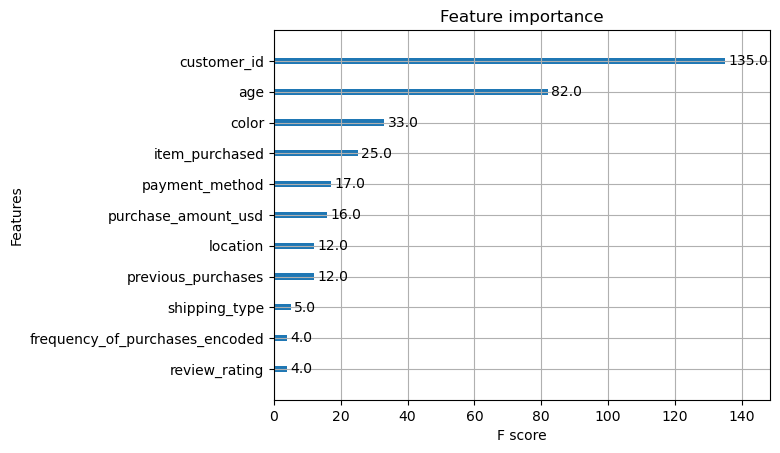

In [24]:
# Importancia de las características
xgb.plot_importance(xgb_model)
plt.show()

**Modelo 3: Stochastic Gradient Boosting**

In [25]:
# Definir el modelo
sgb_model = GradientBoostingClassifier(random_state=42)

# Definir el grid de parámetros
sgb_params_grid = {
    'classify__n_estimators': [100, 200],
    'classify__learning_rate': [0.01, 0.1, 0.2],
    'classify__max_depth': [3, 4, 5],
    'classify__subsample': [0.8, 1.0]
}

In [26]:
sgb_best_params_grid = grid_search_function(model= sgb_model, param_grid=sgb_params_grid, X_train=X_train, y_train=y_train)

In [27]:
xgb_model = train(model=xgb_model, best_params=xgb_best_params_grid)

In [28]:
y_pred = test(model=extra_trees_model, is_classification=True)

              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99       692
         1.0       0.98      0.99      0.99       283

    accuracy                           0.99       975
   macro avg       0.99      0.99      0.99       975
weighted avg       0.99      0.99      0.99       975



#### Vooting

**Modelo 1: Hard Voting:**

In [29]:
# Crear un VotingClassifier con hard voting
voting_clf_hard_model = VotingClassifier(estimators=[('rf', random_forest_model), ('xgb', xgb_model)],
                              voting='hard') 

In [30]:
voting_clf_hard_model = train(model= voting_clf_hard_model)

In [31]:
y_pred = test(model=voting_clf_hard_model, is_classification=True)

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       692
         1.0       1.00      1.00      1.00       283

    accuracy                           1.00       975
   macro avg       1.00      1.00      1.00       975
weighted avg       1.00      1.00      1.00       975



**Modelo 2: Soft Voting**

In [32]:
voting_clf_soft_model = VotingClassifier(estimators=[('rf', random_forest_model), ('xgb', xgb_model)],
                              voting='soft',
                              weights=[1, 1]) 

In [33]:
voting_clf_soft_model = train(model= voting_clf_soft_model)

In [34]:
y_pred = test(model=voting_clf_soft_model, is_classification=True)

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       692
         1.0       1.00      1.00      1.00       283

    accuracy                           1.00       975
   macro avg       1.00      1.00      1.00       975
weighted avg       1.00      1.00      1.00       975



### Guardado del mejor modelo

In [36]:
# Guardar el modelo entrenado en un archivo .pkl
path_best_ml_model = '../models/subscription_status_extra_trees_model.pkl'
joblib.dump(extra_trees_model, path_best_ml_model)

['../models/subscription_status_extra_trees_model.pkl']

### Observaciones de esta etapa:

..